In [2]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import folium
import geopandas as gpd
import re

In [3]:
pd.set_option('display.max_rows', 99999)
pd.set_option('display.max_colwidth', 400)
# pd.describe_option('max_colwidth')

In [4]:
# Load the dataset
listings = pd.read_csv("https://storage.googleapis.com/public-data-337819/listings%202%20reduced.csv",low_memory=False)
reviews = pd.read_csv("https://storage.googleapis.com/public-data-337819/reviews%202%20reduced.csv",low_memory=False)

In [5]:
len(listings)

87946

In [6]:
len(reviews)

1581033

In [7]:
# Check the first few rows
print(listings.head(20).to_markdown())

|    |     id | listing_url                         |      scrape_id | last_scraped   | source          | name                                                                           | description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [8]:
print(reviews.head().to_markdown())

|    |   listing_id |     id | date       |   reviewer_id | reviewer_name   | comments                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
|---:|-------------:|-------:|:-----------|---

In [9]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [10]:
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [11]:
listings.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                                object
host_thumbnail_url                               object
host_picture_url                                 object
host_neighbourhood                               object
host_listings_count                             float64
host_total_listings_count                       float64
host_verifications                               object
host_has_profile_pic                             object
host_identity_verified                           object
neighbourhood                                    object
neighbourhood_cleansed                           object
neighbourhood_group_cleansed                    float64
latitude                                        float64
longitude                                       float64
property_type                                    object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bathrooms_text                                   object
bedrooms                                        float64
beds                                            float64
amenities                                        object
price                                            object
minimum_nights                                    int64
maximum_nights                                    int64
minimum_minimum_nights                          float64
maximum_minimum_nights                          float64
minimum_maximum_nights                          float64
maximum_maximum_nights                          float64
minimum_nights_avg_ntm                          float64
maximum_nights_avg_ntm                          float64
calendar_updated                                float64
has_availability                                 object
availability_30                                   int64
availability_60                                   int64
availability_90                                   int64
availability_365                                  int64
calendar_last_scraped                            object
number_of_reviews                                 int64
number_of_reviews_ltm                             int64
number_of_reviews_l30d                            int64
first_review                                     object
last_review                                      object
review_scores_rating                            float64
review_scores_accuracy                          float64
review_scores_cleanliness                       float64
review_scores_checkin                           float64
review_scores_communication                     float64
review_scores_location                          float64
review_scores_value                             float64
license                                          object
instant_bookable                                 object
calculated_host_listings_count                    int64
calculated_host_listings

In [12]:
reviews.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

#Data cleaning

In [13]:
# Check for missing values for listings
print(listings.isnull().sum())

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
name                                                0
description                                      1267
neighborhood_overview                           40756
picture_url                                         3
host_id                                             0
host_url                                            0
host_name                                           5
host_since                                          5
host_location                                   18778
host_about                                      42040
host_response_time                              28918
host_response_rate                              28918
host_acceptance_rate                            25188
host_is_superhost           

In [14]:
# droppping rows which hostname is unavailable since inaccuracy could be a problem later
listings.dropna(subset=['host_name'], inplace=True)

In [15]:
# dropping columns that are not significant or could be unethical to use for our future data exploration and predictions
listings.drop(['id','host_name','last_review'], axis=1, inplace=True)

In [16]:
# Fill missing values or drop rows/columns with too many NaNs
listings.fillna({'reviews_per_month': 0,'bedrooms': 0,'beds': 0}, inplace=True)

In [17]:
# extract funtion to get number out of bathrooms text
def extract_bathroom_number(text):
  if pd.isna(text):
    return 0
  match = re.search(r"(\d+(?:\.\d+)?)", text)
  if match:
    return float(match.group(1))
  else:
    return 0

# Fill missing values of bathrooms with bathrooms text number
listings['bathrooms'] = listings['bathrooms_text'].apply(extract_bathroom_number)

In [18]:
# Convert price to numeric (if it's a string with symbols like "$")
listings['price'] = listings['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [19]:
neighborhoods_to_replace = ['London, United Kingdom', 'London, England, United Kingdom', 'London, Greater London, United Kingdom',
                            'Greater London, United Kingdom', 'London , England, United Kingdom', 'London, UK, United Kingdom',
                            'Greater London, En, United Kingdom', 'London, England, United Kingdom', 'London, ., United Kingdom',
                            'London, England, United Kingdom', 'London , London, United Kingdom', 'Greater London, London, United Kingdom']

# Replace the values in the 'neighbourhood' column with all similar values for futher analysis
listings['neighbourhood'] = listings['neighbourhood'].replace(neighborhoods_to_replace, 'Greater London, England, United Kingdom')

In [20]:
listings.describe()[['price', 'accommodates', 'bedrooms', 'number_of_reviews', 'review_scores_rating','reviews_per_month',
                                     'host_total_listings_count', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60',
                                     'availability_90', 'availability_365', ]]


price  accommodates      bedrooms  number_of_reviews  \
count  87941.000000  87941.000000  87941.000000       87941.000000   
mean     181.357649      3.165475      1.120024          17.978258   
std      486.187009      1.980408      1.231689          42.835978   
min        0.000000      1.000000      0.000000           0.000000   
25%       63.000000      2.000000      0.000000           0.000000   
50%      110.000000      2.000000      1.000000           4.000000   
75%      193.000000      4.000000      2.000000          16.000000   
max    80100.000000     16.000000     50.000000        1536.000000   

       review_scores_rating  reviews_per_month  host_total_listings_count  \
count          65788.000000       87941.000000               87941.000000   
mean               4.596540           0.759241                  85.809804   
std                0.750778           1.260513                 523.634388   
min                0.000000           0.000000                   1.000000   
25%                4.500000           0.000000                   1.000000   
50%                4.820000           0.250000                   3.000000   
75%                5.000000           1.000000                  10.000000   
max                5.000000          50.250000                5272.000000   

       minimum_nights  maximum_nights  availability_30  availability_60  \
count    87941.000000    8.794100e+04     87941.000000     87941.000000   
mean         5.618164    6.712879e+03         7.822108        18.681036   
std         23.572629    1.770460e+06        10.344598        21.884214   
min          1.000000    1.000000e+00         0.000000         0.000000   
25%          1.000000    5.500000e+01         0.000000         0.000000   
50%          2.000000    3.650000e+02         1.000000         7.000000   
75%          4.000000    1.125000e+03        14.000000        37.000000   
max       1125.000000    5.248556e+08        30.000000        60.000000   

       availability_90  availability_365  
count     87941.000000      87941.000000  
mean         31.368463        121.119694  
std          34.303665        134.554828  
min           0.000000          0.000000  
25%           0.000000          0.000000  
50%          14.000000         65.000000  
75%          65.000000        249.000000  
max          90.000000        365.000000

In [21]:
# Check for missing values in reviews
reviews.isnull().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         159
dtype: int64

In [22]:
# Fill missing values or drop rows/columns with too many NaNs since for sentimental anlysis later
reviews.dropna(subset=['comments'], inplace=True)

#Data analysis

In [ ]:
# let's proceed with examing some interesting categorical unique values
# examining the unique values of n_group as this column will appear very handy for later analysis
listings.neighbourhood_cleansed.unique()

array(['Wandsworth', 'Hammersmith and Fulham', 'Islington',
       'Kensington and Chelsea', 'Greenwich', 'Westminster',
       'Tower Hamlets', 'Barnet', 'Lewisham', 'Brent', 'Lambeth',
       'Richmond upon Thames', 'Haringey', 'Southwark', 'Enfield',
       'Hounslow', 'Camden', 'Waltham Forest', 'City of London',
       'Hackney', 'Ealing', 'Croydon', 'Merton', 'Havering', 'Harrow',
       'Newham', 'Hillingdon', 'Barking and Dagenham', 'Bromley',
       'Kingston upon Thames', 'Redbridge', 'Bexley', 'Sutton'],
      dtype=object)

In [ ]:
# examining the unique values of neighbourhood as this column will appear very handy for later analysis
len(listings.neighbourhood.unique())

872

In [ ]:
# examining the unique values of room_type as this column will appear very handy for later analysis
listings.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

In [ ]:
#we will skip first column for now and begin from host_id

#let's see what hosts (IDs) have the most listings on Airbnb platform and taking advantage of this service
top_host = listings.host_id.value_counts().head(10)
top_host

host_id
129230780    595
33889201     312
314162972    301
28820321     288
1432477      259
258154594    233
269308503    202
48165024     200
156158778    195
439074505    170
Name: count, dtype: int64

In [ ]:
#coming back to our dataset we can confirm our fidnings with already existing column called 'calculated_host_listings_count'
top_host_check = listings.calculated_host_listings_count.max()
top_host_check

595

In [ ]:
#setting figure size for future visualizations
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style('white')

In [ ]:
top_host_df = pd.DataFrame(top_host)
top_host_df.reset_index(inplace=True)
top_host_df.rename(columns={'host_id':'Host_ID', 'count':'P_Count'}, inplace=True)
top_host_df

Host_ID  P_Count
0  129230780      595
1   33889201      312
2  314162972      301
3   28820321      288
4    1432477      259
5  258154594      233
6  269308503      202
7   48165024      200
8  156158778      195
9  439074505      170

<ipython-input-29-9b87f801dfd1>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  viz_1 = sns.barplot(x="Host_ID", y="P_Count", data=top_host_df,
<ipython-input-29-9b87f801dfd1>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)


[Text(0, 0, '1432477'),
 Text(1, 0, '28820321'),
 Text(2, 0, '33889201'),
 Text(3, 0, '48165024'),
 Text(4, 0, '129230780'),
 Text(5, 0, '156158778'),
 Text(6, 0, '258154594'),
 Text(7, 0, '269308503'),
 Text(8, 0, '314162972'),
 Text(9, 0, '439074505')]

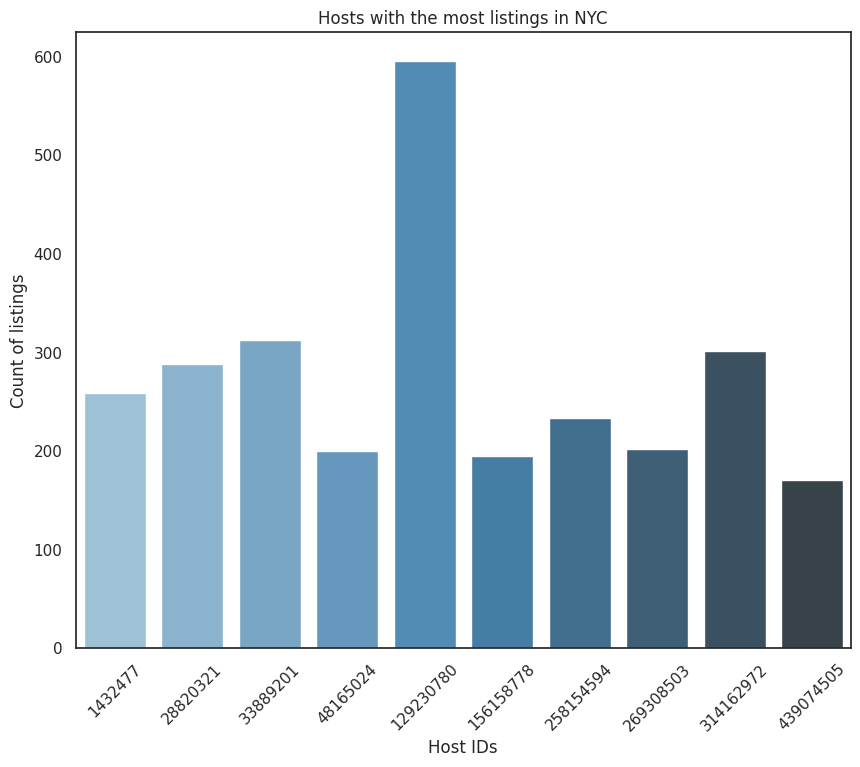

In [ ]:
viz_1 = sns.barplot(x="Host_ID", y="P_Count", data=top_host_df,
                 palette='Blues_d')
viz_1.set_title('Hosts with the most listings in NYC')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Host IDs')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

Interesting, we can see that there is a good distribution between top 10 hosts with the most listings. One host has more than 500+ listings.

In [ ]:
# let's find out more about our neiberhoods presented below

#creating list with known values in neighbourhood_group column
neighbours_list = ['Wandsworth', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Greenwich', 'Westminster','Tower Hamlets',
                   'Barnet', 'Lewisham', 'Brent', 'Lambeth', 'Richmond upon Thames', 'Haringey', 'Southwark', 'Enfield','Hounslow', 'Camden',
                   'Waltham Forest', 'City of London', 'Hackney', 'Ealing', 'Croydon', 'Merton', 'Havering', 'Harrow', 'Newham', 'Hillingdon',
                   'Barking and Dagenham', 'Bromley', 'Kingston upon Thames', 'Redbridge', 'Bexley', 'Sutton']

price_list_by_n = []
for neighbour in neighbours_list:
  sub = listings.loc[listings['neighbourhood_cleansed'] == neighbour]
  price_sub = sub[['price']]
  price_list_by_n.append(price_sub)

In [ ]:
#creating an empty list that we will append later with price distributions for each neighbourhood_group
p_l_b_n_2 = []

#creating a for loop to get statistics for price ranges and append it to our empty list
for x in price_list_by_n:
    i = x.describe(percentiles=[.25, .50, .75])
    i = i.iloc[3:]
    i.reset_index(inplace = True)
    i.rename(columns = {'index':'Stats'}, inplace=True)
    p_l_b_n_2.append(i)

#changing names of the price column to the area name for easier reading of the table
for i in range(len(p_l_b_n_2)):
    p_l_b_n_2[i].rename(columns = {'price':neighbours_list[i]}, inplace = True)

#finilizing our dataframe for final view
stat_df = p_l_b_n_2
stat_df = [df.set_index('Stats') for df in stat_df]
stat_df = stat_df[0].join(stat_df[1:])
print(stat_df.to_markdown())

| Stats   |   Wandsworth |   Hammersmith and Fulham |   Islington |   Kensington and Chelsea |   Greenwich |   Westminster |   Tower Hamlets |   Barnet |   Lewisham |   Brent |   Lambeth |   Richmond upon Thames |   Haringey |   Southwark |   Enfield |   Hounslow |   Camden |   Waltham Forest |   City of London |   Hackney |   Ealing |   Croydon |   Merton |   Havering |   Harrow |   Newham |   Hillingdon |   Barking and Dagenham |   Bromley |   Kingston upon Thames |   Redbridge |   Bexley |   Sutton |
|:--------|-------------:|-------------------------:|------------:|-------------------------:|------------:|--------------:|----------------:|---------:|-----------:|--------:|----------:|-----------------------:|-----------:|------------:|----------:|-----------:|---------:|-----------------:|-----------------:|----------:|---------:|----------:|---------:|-----------:|---------:|---------:|-------------:|-----------------------:|----------:|-----------------------:|------------:|-----

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('white')

<ipython-input-36-c7f192c0d798>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  viz_2.set_xticklabels(viz_2.get_xticklabels(), rotation = 90)


[Text(0, 0, 'Wandsworth'),
 Text(1, 0, 'Hammersmith and Fulham'),
 Text(2, 0, 'Islington'),
 Text(3, 0, 'Kensington and Chelsea'),
 Text(4, 0, 'Greenwich'),
 Text(5, 0, 'Westminster'),
 Text(6, 0, 'Tower Hamlets'),
 Text(7, 0, 'Barnet'),
 Text(8, 0, 'Lewisham'),
 Text(9, 0, 'Brent'),
 Text(10, 0, 'Lambeth'),
 Text(11, 0, 'Richmond upon Thames'),
 Text(12, 0, 'Haringey'),
 Text(13, 0, 'Southwark'),
 Text(14, 0, 'Enfield'),
 Text(15, 0, 'Hounslow'),
 Text(16, 0, 'Camden'),
 Text(17, 0, 'Waltham Forest'),
 Text(18, 0, 'City of London'),
 Text(19, 0, 'Hackney'),
 Text(20, 0, 'Ealing'),
 Text(21, 0, 'Croydon'),
 Text(22, 0, 'Merton'),
 Text(23, 0, 'Havering'),
 Text(24, 0, 'Harrow'),
 Text(25, 0, 'Newham'),
 Text(26, 0, 'Hillingdon'),
 Text(27, 0, 'Barking and Dagenham'),
 Text(28, 0, 'Bromley'),
 Text(29, 0, 'Kingston upon Thames'),
 Text(30, 0, 'Redbridge'),
 Text(31, 0, 'Bexley'),
 Text(32, 0, 'Sutton')]

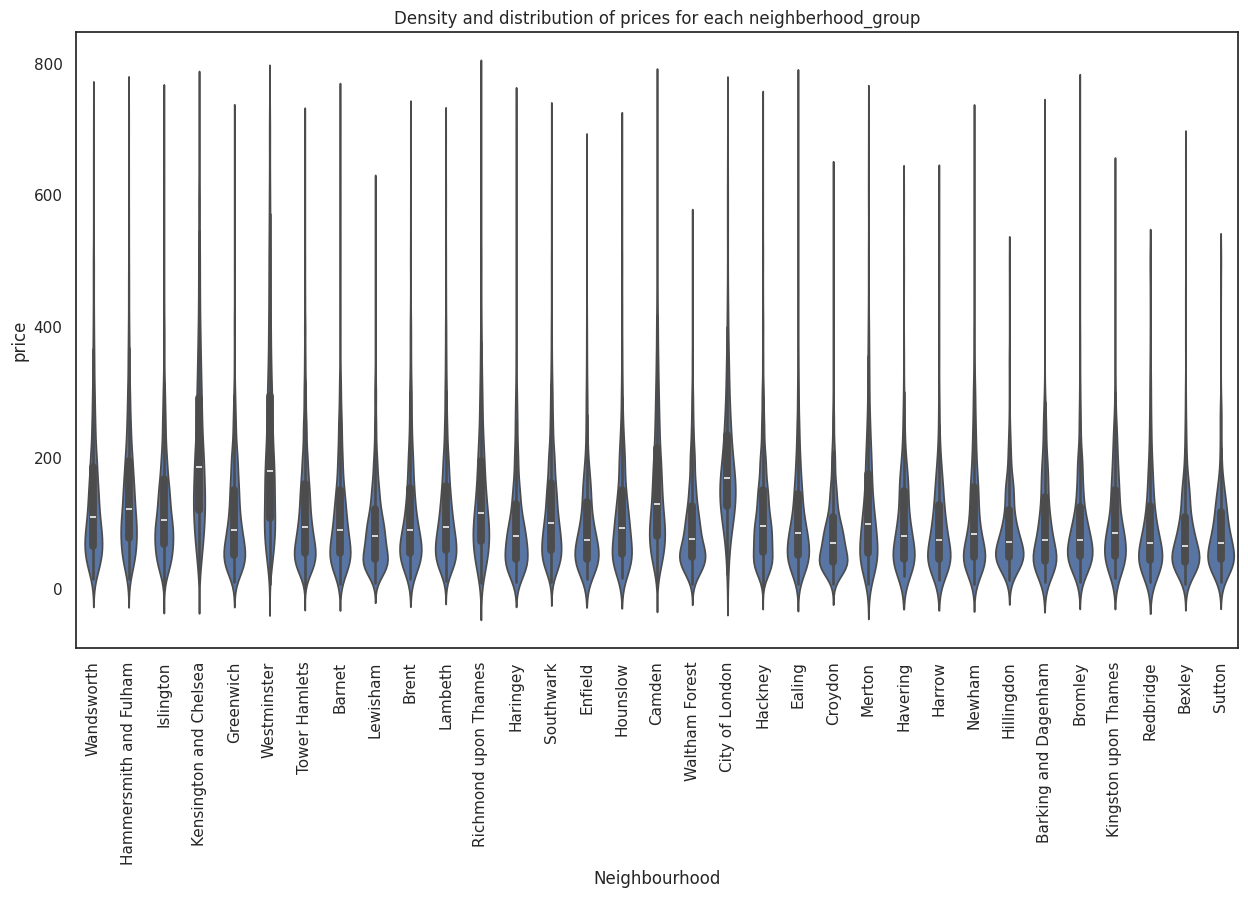

In [ ]:
#we can see from our statistical table that we have some extreme values, therefore we need to remove them for the sake of a better visualization

#creating a sub-dataframe with no extreme values / less than 500
sub_6 = listings[listings.price < 750]

#using violinplot to showcase density and distribtuion of prices
viz_2 = sns.violinplot(data = sub_6, x = 'neighbourhood_cleansed', y = 'price')
viz_2.set_title('Density and distribution of prices for each neighberhood_group')
viz_2.set_xlabel('Neighbourhood')
viz_2.set_xticklabels(viz_2.get_xticklabels(), rotation = 90)

In [ ]:
#as we saw earlier from unique values for neighbourhood there are way too many to concentrate on;
#therefore, let's grab just top 10 neighbourhoods that have the most listings in them

#finding out top 10 neighbourhoods and print in array format
listings.neighbourhood.value_counts().head(10)
# .index.tolist()


neighbourhood
Greater London, England, United Kingdom    44708
Wembley Park, England, United Kingdom        119
England, United Kingdom                       74
Twickenham, United Kingdom                    38
Richmond, England, United Kingdom             31
Kingston upon Thames, United Kingdom          29
Harlington, England, United Kingdom           29
Croydon, England, United Kingdom              26
Richmond, United Kingdom                      26
Woodford, England, United Kingdom             26
Name: count, dtype: int64

In [ ]:
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('white')

Text(0.5, 0.98, 'Neighborhood Counts for all Room Types')

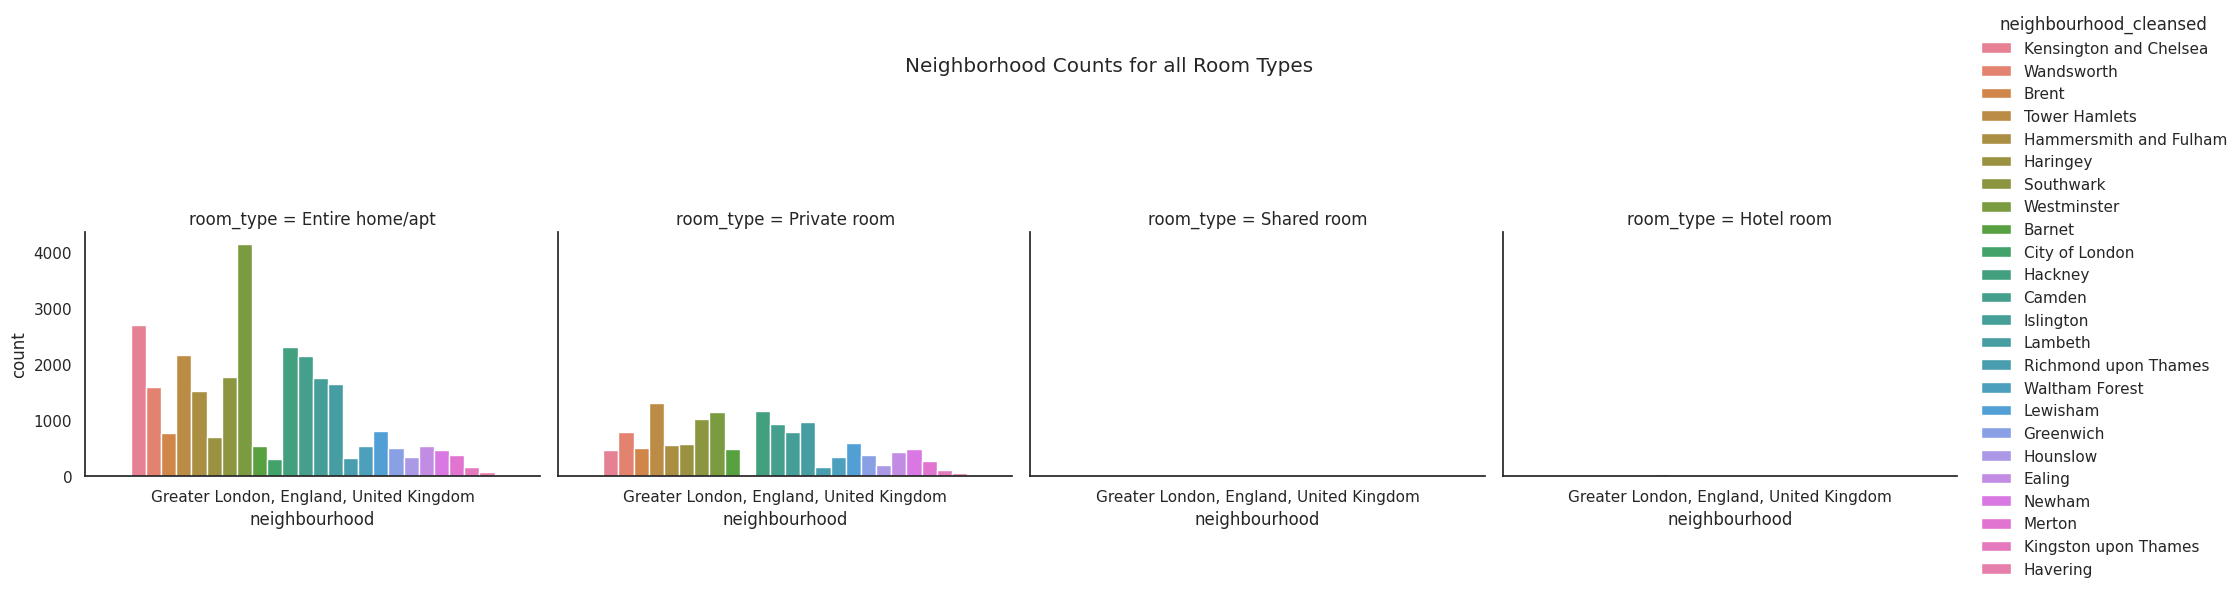

In [ ]:
# let's now combine this with our boroughs and room type for a rich visualization we can make

# grabbing top 10 neighbourhoods for sub-dataframe
sub_7 = listings.loc[listings['neighbourhood'].isin(['Greater London, England, United Kingdom'])
# ,'Wembley Park, England, United Kingdom',
#                                                     'England, United Kingdom','Twickenham, United Kingdom',
#                                                     'Richmond, England, United Kingdom','Harlington, England, United Kingdom',
#                                                     'Kingston upon Thames, United Kingdom','Richmond, United Kingdom',
#                                                     'Woodford, England, United Kingdom','Croydon, England, United Kingdom'])
                      & ~listings['neighbourhood_cleansed'].isin(['Bexley', 'Sutton', 'Redbridge', 'Bromley', 'Barking and Dagenham',
                                                                      'Hillingdon', 'Harrow', 'Croydon', 'Waltham' 'Forest', 'Enfield'])]


# using catplot to represent multiple interesting attributes together and a count
room_types = listings['room_type'].unique()

viz_3 = sns.catplot(x = 'neighbourhood', hue = 'neighbourhood_cleansed', col = 'room_type', data = sub_7, kind='count')
viz_3.fig.suptitle(f'Neighborhood Counts for all Room Types')
# viz_3.set_xticklabels(rotation=90)

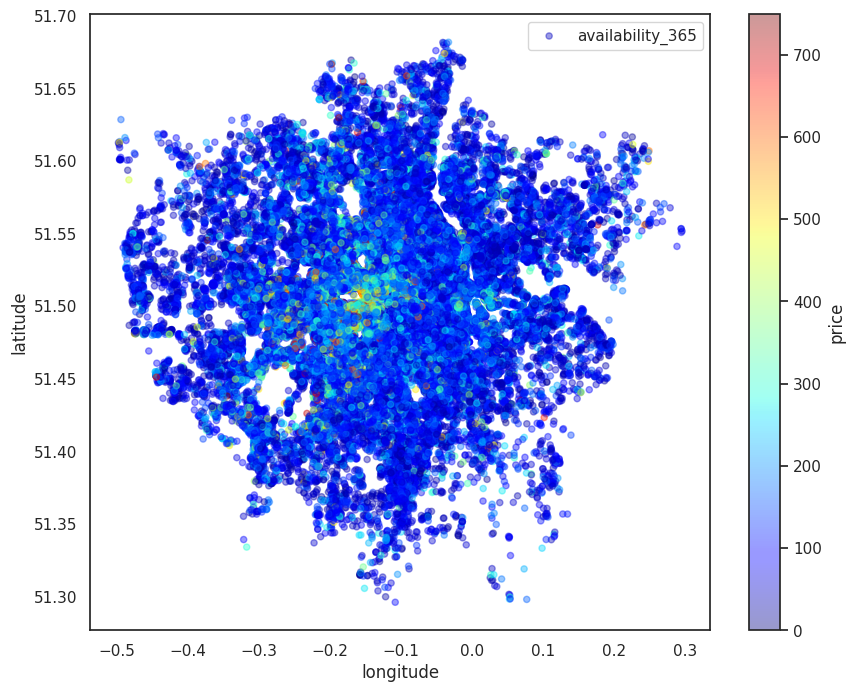

In [ ]:
#let's what we can do with our given longtitude and latitude columns

#let's see how scatterplot will come out
viz_4 = sub_6.plot(kind = 'scatter', x = 'longitude', y = 'latitude', label = 'availability_365', c = 'price',
                  cmap = plt.get_cmap('jet'), colorbar = True, alpha = 0.4, figsize = (10,8))
viz_4.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


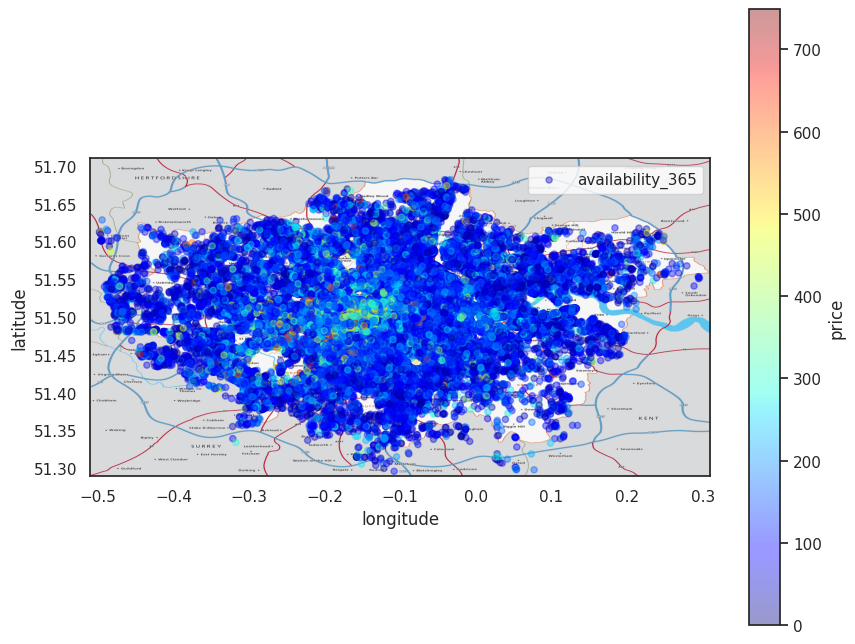

In [ ]:
import urllib
#initializing the figure size
plt.figure(figsize = (10,8))
#loading the jpg london image found on Google and saving to my local folder along with the project
# urllib.request.urlretrieve('https://londonmap360.com/website/var/tmp/image-thumbnails/0/871/thumb__map/london-borough-map.pjpeg', 'london_image.jpg')
london_img = plt.imread('/content/drive/MyDrive/Airbnb/london.jpg')
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(london_img, zorder = 0,extent = [-0.51, 0.31, 51.29, 51.71])
ax = plt.gca()
#using scatterplot again
sub_6.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price', ax=ax,
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)

plt.legend()
plt.show()

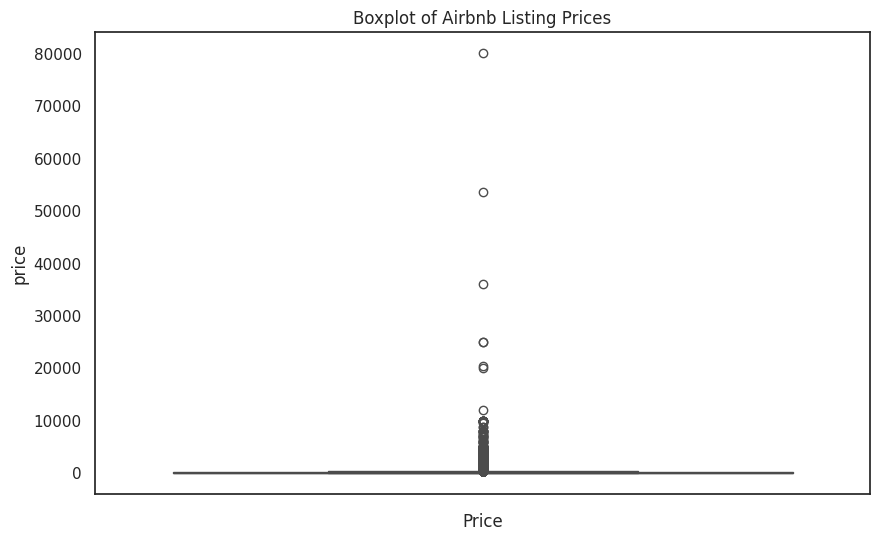

In [ ]:
# Boxplot to visualize price outliers
plt.figure(figsize=(10, 6))
sns.boxplot(listings['price'])
plt.title('Boxplot of Airbnb Listing Prices')
plt.xlabel('Price')
plt.show()

In [ ]:
# Calculate IQR
Q1 = listings['price'].quantile(0.25)
Q3 = listings['price'].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = listings[(listings['price'] < lower_bound) | (listings['price'] > upper_bound)]
print("Number of outliers in price:", outliers.shape[0])

# Show outliers
outliers[['price', 'name', 'room_type', 'number_of_reviews']]


Output hidden; open in https://colab.research.google.com to view.

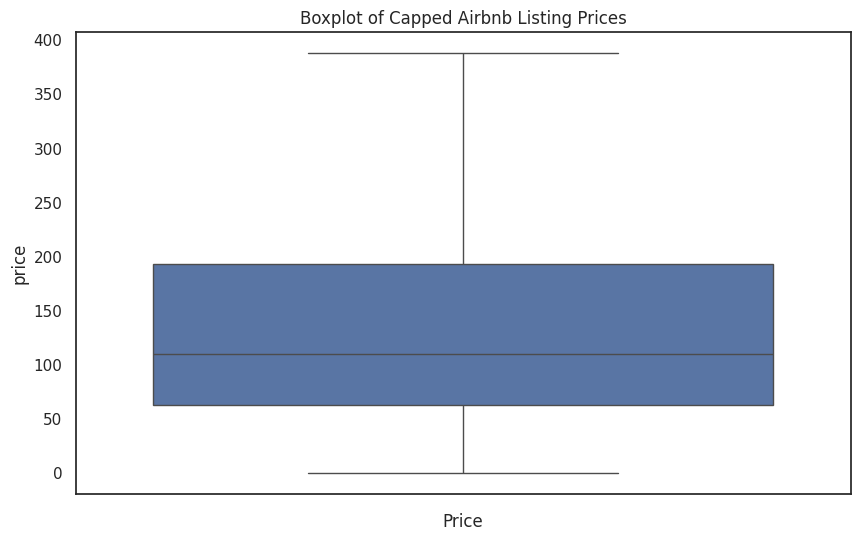

In [ ]:
# why -> outliers represent valid listings (e.g., luxury properties or rare exceptions),
#  hence using capping or log transformation to handle the extreme values while preserving the data integrity.

# Cap outliers to the IQR range
listings['price'] = np.where(listings['price'] > upper_bound, upper_bound,
               np.where(listings['price'] < lower_bound, lower_bound, listings['price']))

# Check the updated boxplot to verify capping
plt.figure(figsize=(10, 6))
sns.boxplot(listings['price'])
plt.title('Boxplot of Capped Airbnb Listing Prices')
plt.xlabel('Price')
plt.show()

In [ ]:
# Check data types and clean further if necessary
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87941 entries, 0 to 87945
Data columns (total 72 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   87941 non-null  object 
 1   scrape_id                                     87941 non-null  int64  
 2   last_scraped                                  87941 non-null  object 
 3   source                                        87941 non-null  object 
 4   name                                          87941 non-null  object 
 5   description                                   86674 non-null  object 
 6   neighborhood_overview                         47189 non-null  object 
 7   picture_url                                   87938 non-null  object 
 8   host_id                                       87941 non-null  int64  
 9   host_url                                      87941 non-null  obje

In [ ]:
listings['bathrooms'].unique()

array([ 1.5,  1. ,  2. ,  0. ,  2.5,  4. ,  3. ,  3.5,  4.5,  5. ,  7. ,
        6. ,  5.5, 10. , 17. ,  7.5,  8. , 10.5,  6.5, 12. , 13. , 16. ,
        8.5, 16.5, 12.5, 48. ,  9. , 23. , 22. ,  9.5])

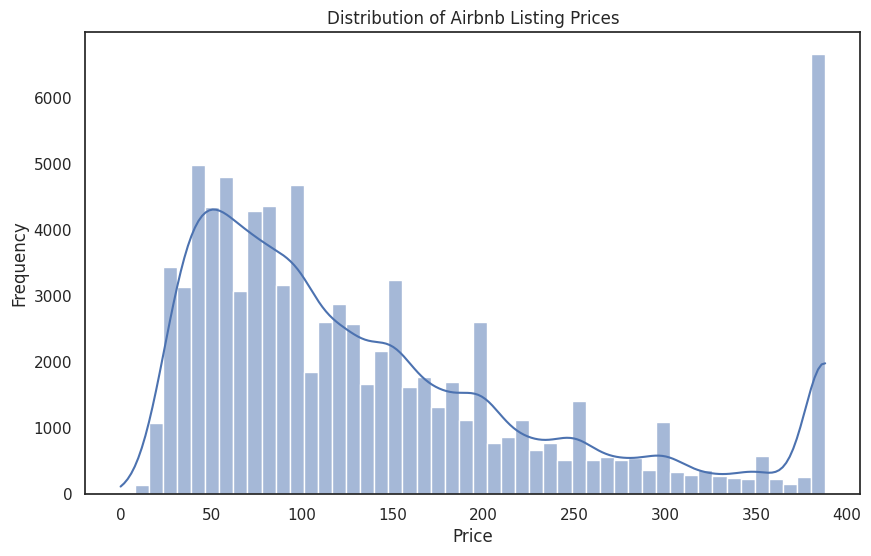

In [ ]:
# Distribution of Prices
plt.figure(figsize=(10, 6))
sns.histplot(listings['price'], bins=50, kde=True)
plt.title('Distribution of Airbnb Listing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % listings['price'].skew())
print("Kurtosis: %f" % listings['price'].kurt())

Skewness: 1.088995
Kurtosis: 0.217345


looks the skew and kurtosis came out very large. Since the skewness has value>1 it is highly skewed.
Also kurtosis looks high as well which indicates presence of good amount of outliers,we will look later into that when we handle outliers!!

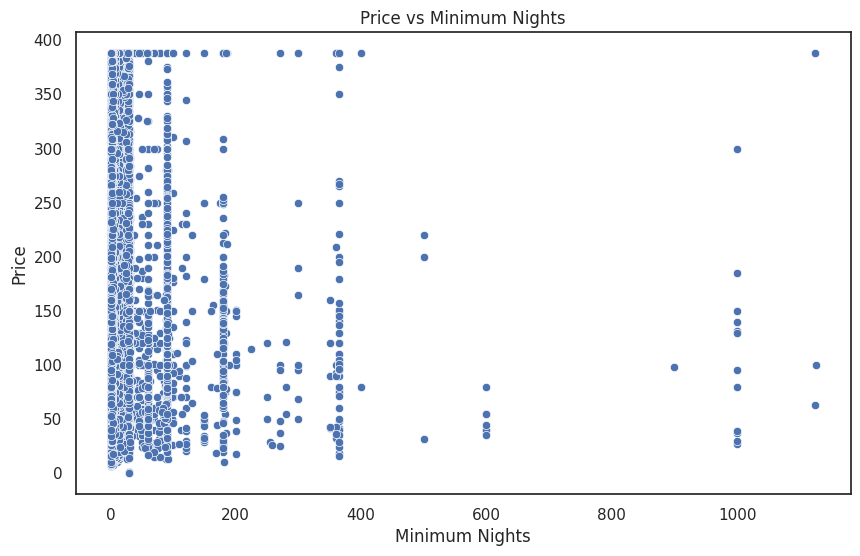

In [ ]:
# Scatter plot of price vs. number of reviews
plt.figure(figsize=(10, 6))
sns.scatterplot(x='minimum_nights', y='price', data=listings)
plt.title('Price vs Minimum Nights')
plt.xlabel('Minimum Nights')
plt.ylabel('Price')
plt.show()

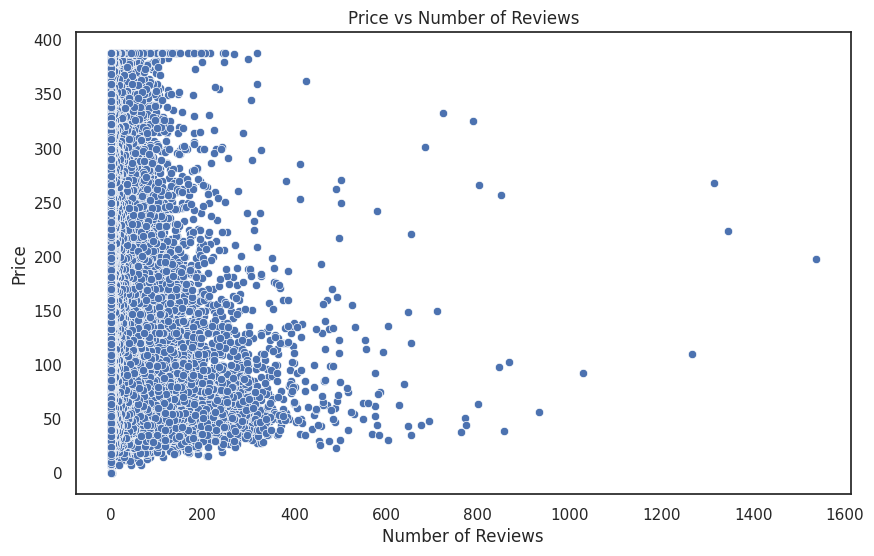

In [ ]:
# Scatter plot of price vs. number of reviews
plt.figure(figsize=(10, 6))
sns.scatterplot(x='number_of_reviews', y='price', data=listings)
plt.title('Price vs Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.show()

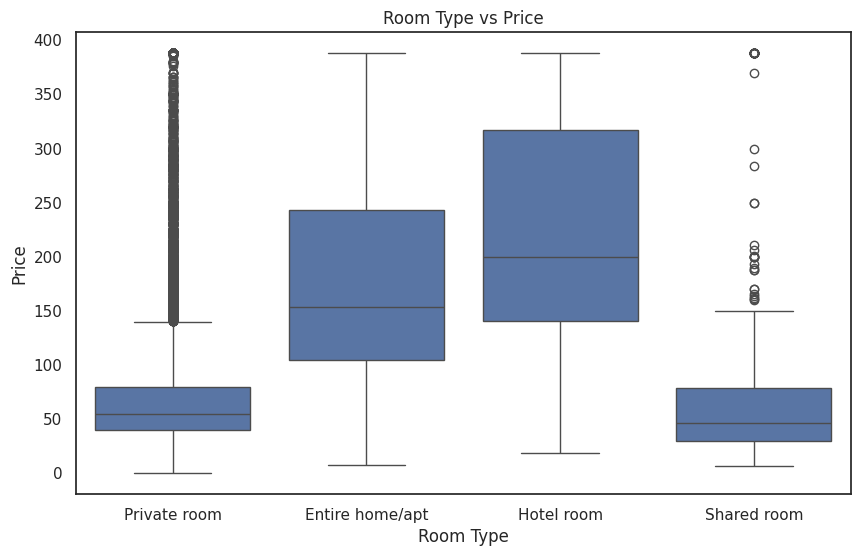

In [ ]:
# Room type vs Price
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=listings)
plt.title('Room Type vs Price')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

In [ ]:
#last column we need to look at is 'number_of_reviews'

#let's grab 10 most reviewed listings in NYC
top_reviewed_listings = listings.nlargest(10,'number_of_reviews')
top_reviewed_listings[["name","price","room_type","number_of_reviews","reviews_per_month"]]

name  \
29831          Boutique hotel in Bayswater · ★4.54 · 1 bedroom · 1 bed · 1 private bath   
42982              Hotel in Greater London · ★4.46 · 1 bedroom · 1 bed · 1 private bath   
18366                   Rental unit in Greater London · ★4.78 · Studio · 1 bed · 1 bath   
40367                      Hotel in Greater London · ★4.51 · 1 bedroom · 1 bed · 1 bath   
1378                 Townhouse in London · ★4.61 · 1 bedroom · 1 bed · 1.5 shared baths   
1769          Rental unit in Greater London · ★4.91 · 1 bedroom · 1 bed · 1 shared bath   
1380                        Townhouse in London · ★4.70 · 1 bedroom · 1 bed · 1.5 baths   
20810            Rental unit in Harlington · ★4.68 · 1 bedroom · 1 bed · 1 private bath   
41489  Bed and breakfast in Greater London · ★4.41 · 1 bedroom · 1 bed · 1 private bath   
2880                      Home in London · ★4.73 · 1 bedroom · 1 bed · 1.5 shared baths   

       price        room_type  number_of_reviews  reviews_per_month  
29831  198.0     Private room               1536              27.38  
42982  224.0     Private room               1345              50.25  
18366  268.0  Entire home/apt               1314              20.41  
40367  110.0     Private room               1267              32.80  
1378    93.0     Private room               1029               8.47  
1769    57.0     Private room                934               8.16  
1380   103.0     Private room                867               7.08  
20810   39.0     Private room                856              11.97  
41489  257.0     Private room                851              22.98  
2880    98.0     Private room                847               7.76

In [ ]:
price_avrg=top_reviewed_listings.price.mean()
print('Average price per night: {}'.format(price_avrg))

Average price per night: 144.7


Text(0.5, 0, 'Min Stays')

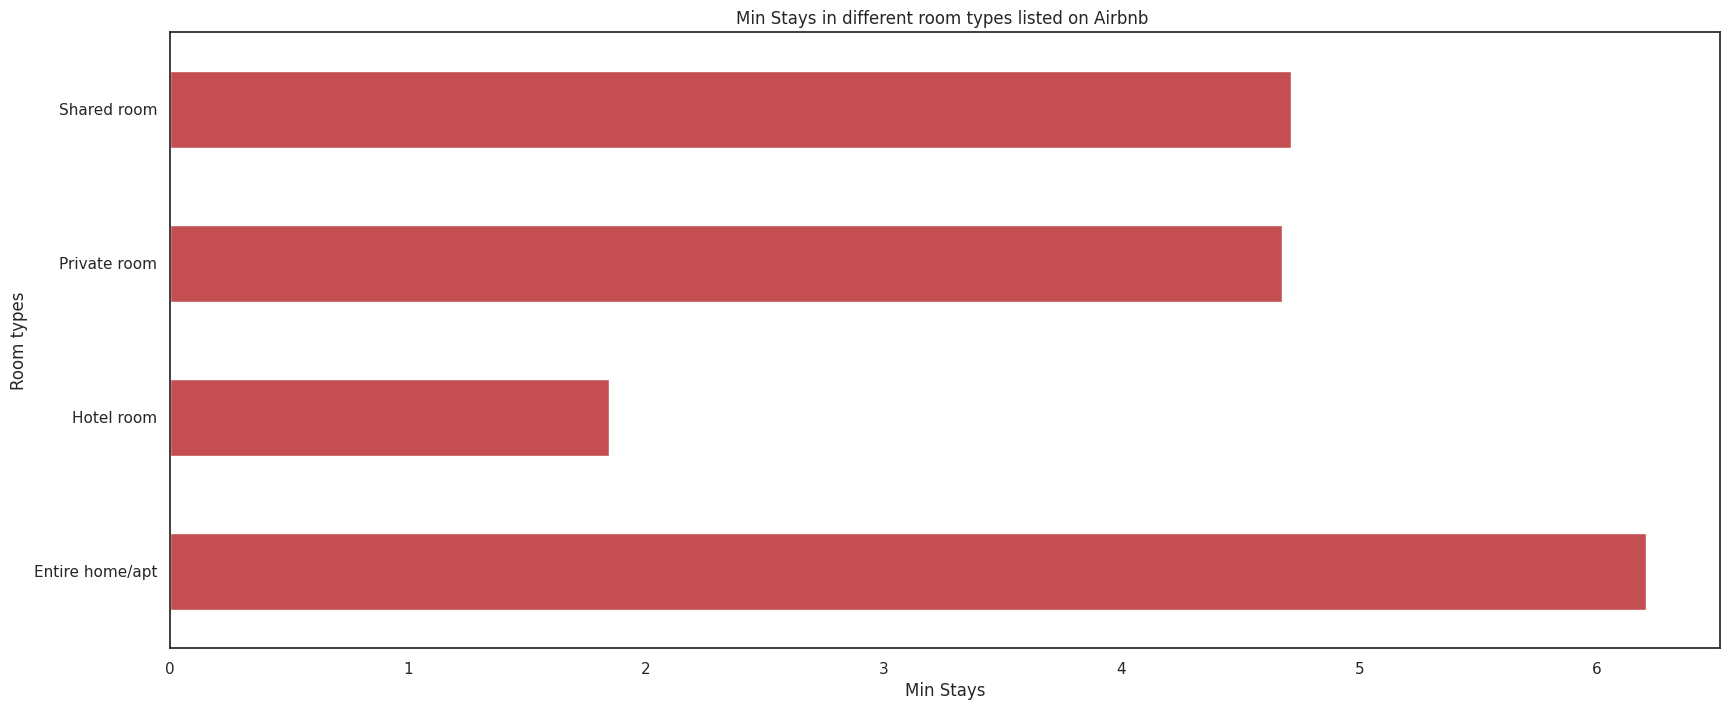

In [ ]:
# On an average for how many nights people stayed in each room_types!
listings.groupby('room_type')['minimum_nights'].mean().plot(kind='barh',color='r')
plt.title('Min Stays in different room types listed on Airbnb ')
plt.ylabel('Room types')
plt.xlabel('Min Stays')

It clearly indicates that guests predominantly choose to reside in an entire home/apt, averaging over 6 nights, compared to those who occupied a shared room, where the typical duration of stay ranges from 4 to 5 nights.

In [ ]:
# How monthly reviews varies with room types in each neighbourhood groups?
#top 10 most reviewed listings in NYC!
top10_reviewed_listings = listings.nlargest(10,'reviews_per_month')
top10_reviewed_listings[['name','reviews_per_month','neighbourhood_cleansed']]

name  \
42982              Hotel in Greater London · ★4.46 · 1 bedroom · 1 bed · 1 private bath   
72620                Rental unit in Greater London · ★4.32 · 1 bedroom · 1 bed · 1 bath   
40367                      Hotel in Greater London · ★4.51 · 1 bedroom · 1 bed · 1 bath   
29831          Boutique hotel in Bayswater · ★4.54 · 1 bedroom · 1 bed · 1 private bath   
43007               Hotel in Greater London · ★4.21 · 1 bedroom · 1 bed · 1 shared bath   
42469                 Aparthotel in Greater London · ★4.69 · 1 bedroom · 1 bed · 1 bath   
41489  Bed and breakfast in Greater London · ★4.41 · 1 bedroom · 1 bed · 1 private bath   
18366                   Rental unit in Greater London · ★4.78 · Studio · 1 bed · 1 bath   
72563                Rental unit in Greater London · ★4.42 · 1 bedroom · 1 bed · 1 bath   
46398                      Condo in Greater London · ★4.84 · 1 bedroom · 1 bed · 1 bath   

       reviews_per_month neighbourhood_cleansed  
42982              50.25                 Camden  
72620              41.79              Islington  
40367              32.80                Hackney  
29831              27.38            Westminster  
43007              24.00                 Camden  
42469              23.58         City of London  
41489              22.98            Westminster  
18366              20.41          Tower Hamlets  
72563              20.36          Tower Hamlets  
46398              19.48          Tower Hamlets

Text(0.5, 1.0, 'Most Reviewed room_types in each Neighbourhood Groups')

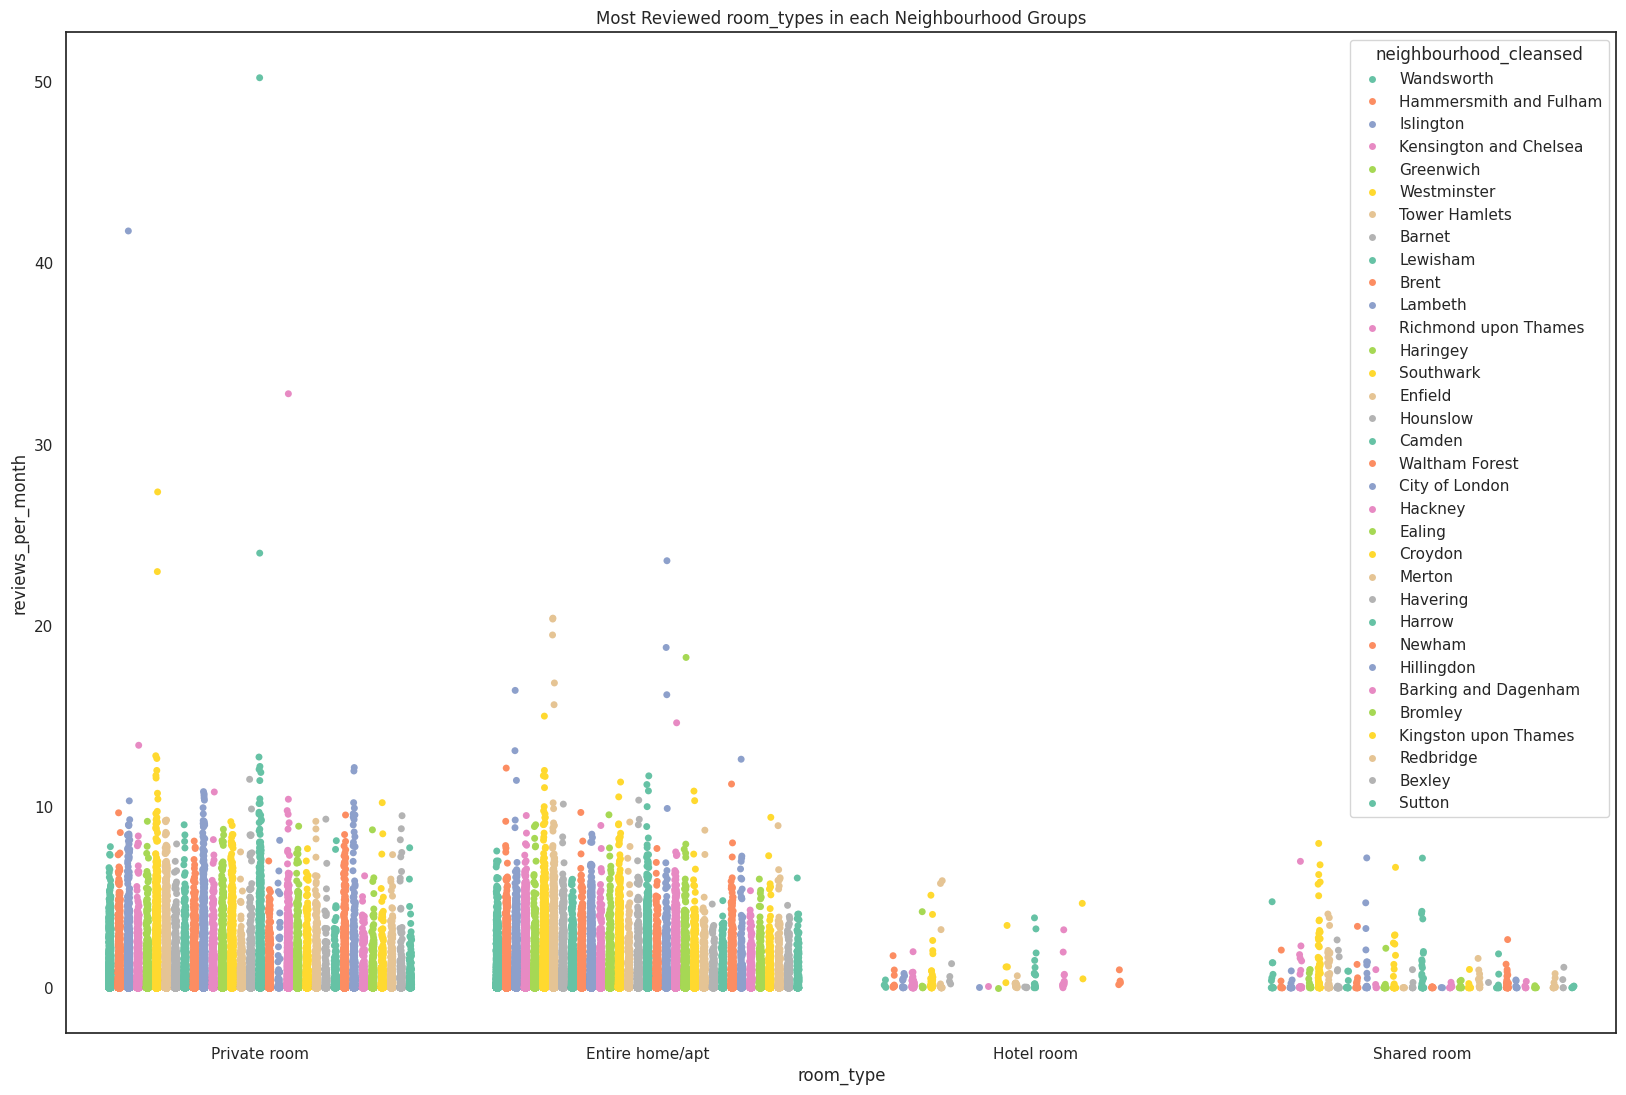

In [ ]:
f,ax = plt.subplots(figsize=(20,13))
ax = sns.stripplot(x = 'room_type', y = 'reviews_per_month', hue = 'neighbourhood_cleansed', dodge = True, data = listings, palette = 'Set2')
ax.set_title('Most Reviewed room_types in each Neighbourhood Groups')

It is evident that Private rooms garnered the highest number of reviews per month, with Camaden leading in this category, accumulating over 50 reviews monthly. Following closely behind was Wandsworth with almost above 40 reviews per month.

Both Westminster and City of London received the greatest number of reviews for the Entire home/apt category.

Shared rooms and Hotel rooms, on the other hand, received fewer reviews than the other types of accommodations, with Lambeth reporting the lowest, followed by the Haringey.

#Text Analysis

In [ ]:
#let's comeback now to the 'name' column as it will require litte bit more coding and continue to analyze it!

#initializing empty list where we are going to put our name strings
_names_=[]
#getting name strings from the column and appending it to the list
for name in listings.name:
    _names_.append(name)
#setting a function that will split those name strings into separate words
def split_name(name):
    spl=str(name).split()
    return spl
#initializing empty list where we are going to have words counted
_names_for_count_=[]
#getting name string from our list and using split function, later appending to list above
for x in _names_:
    for word in split_name(x):
        word=word.lower()
        _names_for_count_.append(word)

In [ ]:
#we are going to use counter
from collections import Counter
#let's see top 25 used words by host to name their listing
_top_25_w=Counter(_names_for_count_).most_common()
_top_25_w=_top_25_w[0:25]

In [ ]:
#now let's put our findings in dataframe for further visualizations
sub_w=pd.DataFrame(_top_25_w)
sub_w.rename(columns={0:'Words', 1:'Count'}, inplace=True)

<ipython-input-61-0e3429d56be5>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  viz_5.set_xticklabels(viz_5.get_xticklabels(), rotation=80)


[Text(0, 0, '·'),
 Text(1, 0, '1'),
 Text(2, 0, 'in'),
 Text(3, 0, 'london'),
 Text(4, 0, 'greater'),
 Text(5, 0, 'bath'),
 Text(6, 0, 'bedroom'),
 Text(7, 0, '2'),
 Text(8, 0, 'bed'),
 Text(9, 0, 'rental'),
 Text(10, 0, 'unit'),
 Text(11, 0, 'beds'),
 Text(12, 0, 'bedrooms'),
 Text(13, 0, 'baths'),
 Text(14, 0, 'home'),
 Text(15, 0, 'shared'),
 Text(16, 0, '3'),
 Text(17, 0, 'condo'),
 Text(18, 0, '★5.0'),
 Text(19, 0, '1.5'),
 Text(20, 0, '★new'),
 Text(21, 0, '4'),
 Text(22, 0, 'private'),
 Text(23, 0, 'studio'),
 Text(24, 0, '2.5')]

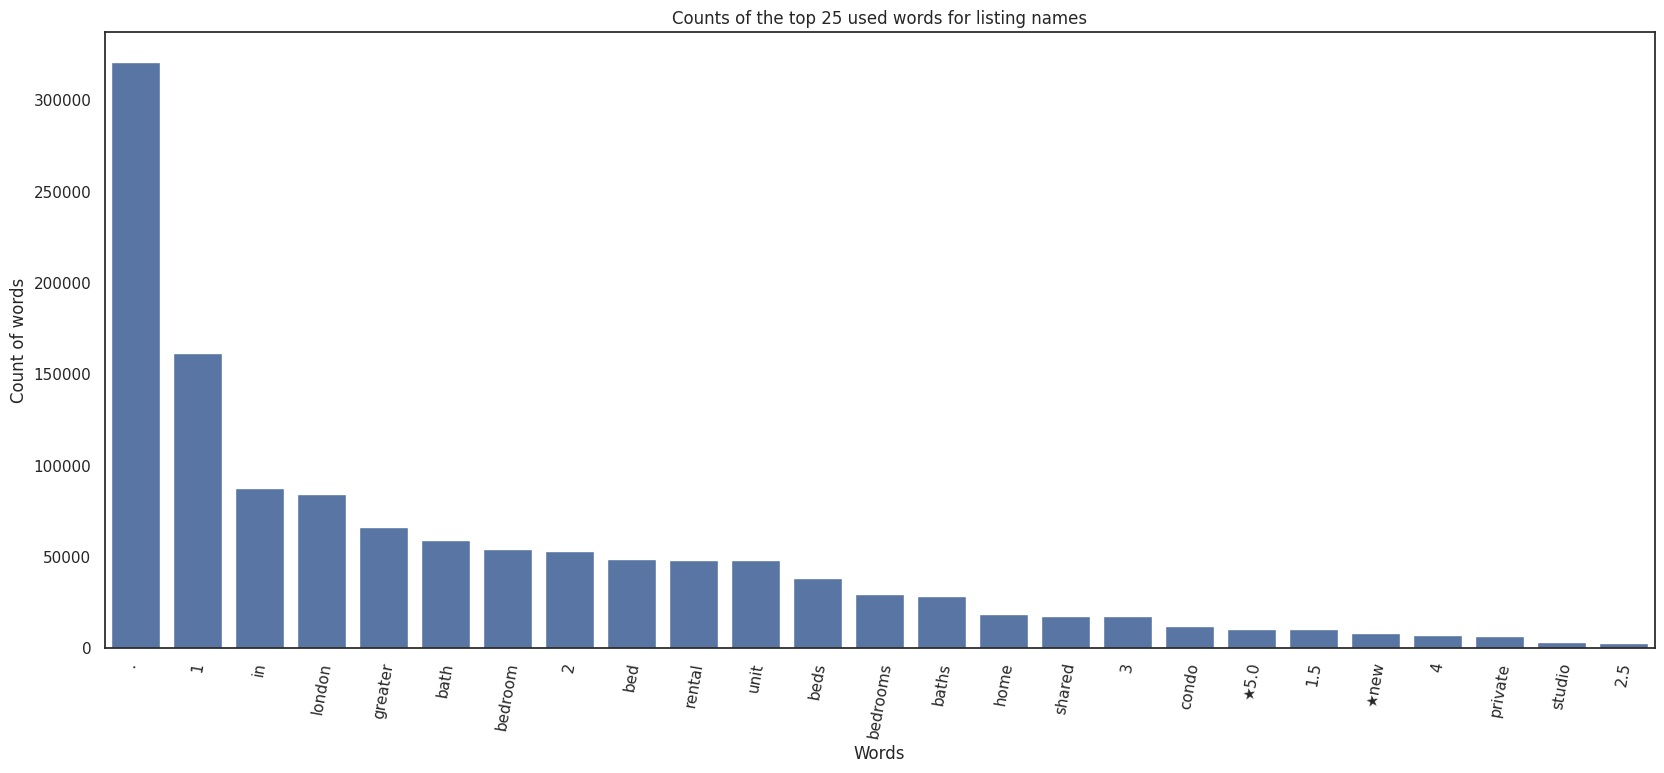

In [ ]:
#we are going to use barplot for this visualization
viz_5=sns.barplot(x='Words', y='Count', data=sub_w)
viz_5.set_title('Counts of the top 25 used words for listing names')
viz_5.set_ylabel('Count of words')
viz_5.set_xlabel('Words')
viz_5.set_xticklabels(viz_5.get_xticklabels(), rotation=80)

Sentimental analysisi

In [47]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Download VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [48]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to classify sentiment based on VADER scores
def get_sentiment_vader(text):
    scores = sid.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
      return 'neutral'

# Apply the function to classify sentiment for each review
reviews['sentiment_vader'] = reviews['comments'].apply(get_sentiment_vader)

# Alternative approach using TextBlob for comparison
def get_sentiment_textblob(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

reviews['sentiment_textblob'] = reviews['comments'].apply(get_sentiment_textblob)

# Show sample reviews with sentiments
print(reviews[['comments', 'sentiment_vader', 'sentiment_textblob']].head())

                                                                                                                                                                                                                                                                                                                                                                                                          comments  \
0  My girlfriend and I hadn't known Alina before we took the leap of faith to rent her flat. Alina just couldn't be nicer! Her flat is comfortable, homey, very sunny, and quiet at night. Her diverse neighborhood rocks! It's full of excellent eateries of varying ethnicities, good supermarkets, etc., etc. Her place is about a 10-minute walk to the Finsbury Park tube stop, and there are also several...   
1                                                                                                                                                                                           

In [49]:
# Choose one sentiment label (e.g., 'sentiment_vader') for training
reviews['sentiment'] = reviews['sentiment_vader']  # You can also use 'sentiment_textblob' for comparison

# Encode sentiment labels
reviews['sentiment_label'] = reviews['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

# Split the data into train and test sets
X = reviews['comments']
y = reviews['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Replace NaN values in X_train with empty strings before applying TfidfVectorizer
X_train = X_train.fillna('')  # Replace NaN values with empty strings
X_test = X_test.fillna('')  # Replace NaN values with empty strings

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [50]:
# Train a logistic regression model
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          -1       0.86      0.79      0.83     13387
           0       0.92      0.94      0.93     29117
           1       0.99      0.99      0.99    273671

    accuracy                           0.98    316175
   macro avg       0.92      0.91      0.91    316175
weighted avg       0.98      0.98      0.98    316175

Confusion Matrix:
[[ 10630    649   2108]
 [   451  27336   1330]
 [  1285   1668 270718]]
Accuracy Score: 0.9763074246856962


<ipython-input-64-7256924598eb>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_vader', data=reviews, palette='viridis')


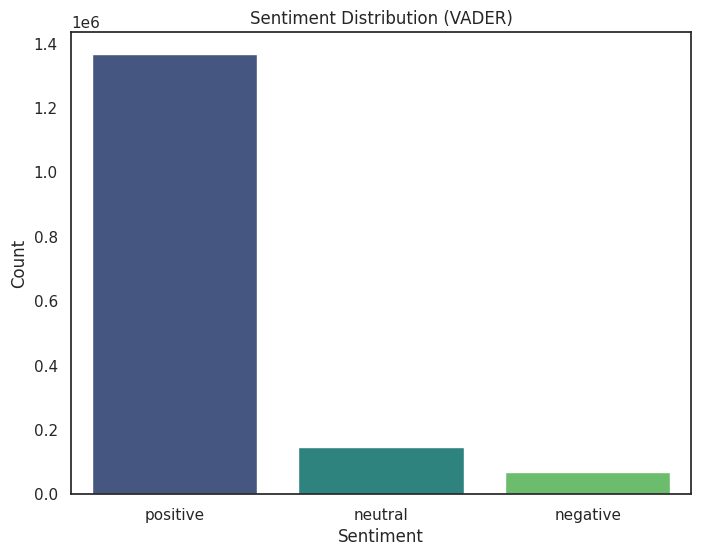

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sentiment distribution of vader
# Plot the distribution of sentiments using VADER or TextBlob sentiment columns
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_vader', data=reviews, palette='viridis')
plt.title('Sentiment Distribution (VADER)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

<ipython-input-65-fbad715bead3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_vader', data=reviews, palette='viridis', ax=axes[0])
<ipython-input-65-fbad715bead3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_textblob', data=reviews, palette='cool', ax=axes[1])


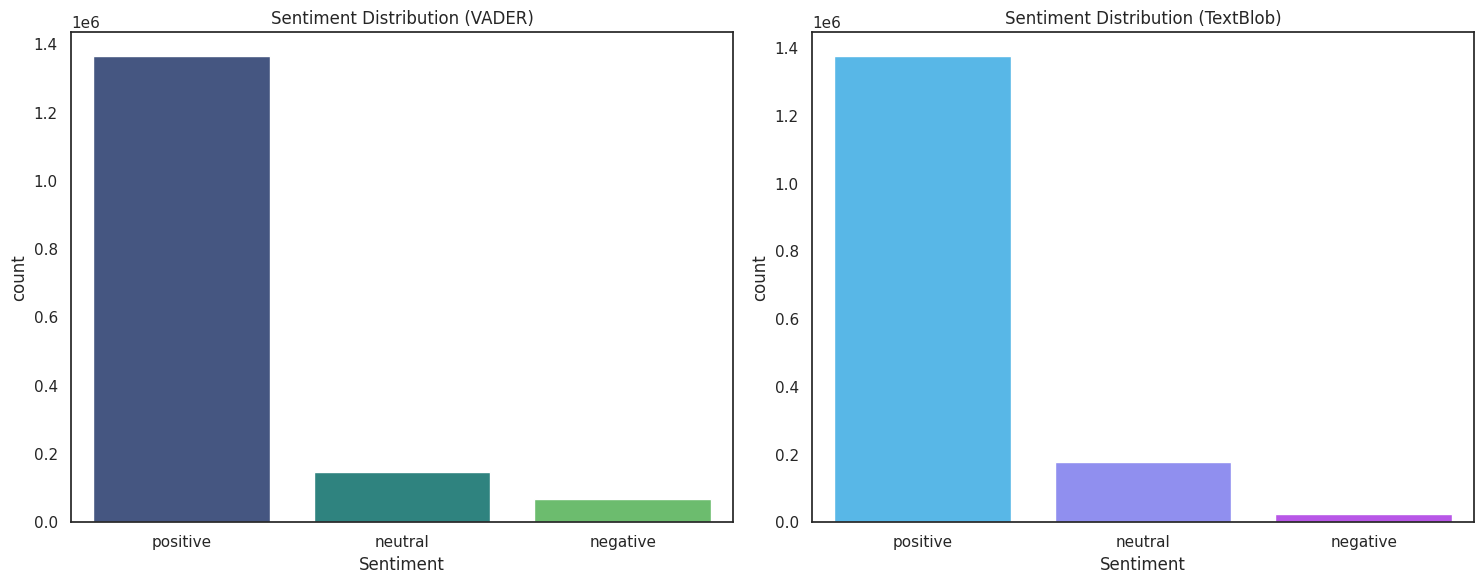

In [ ]:
# sentiment distribution of both vader and textblob at once
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='sentiment_vader', data=reviews, palette='viridis', ax=axes[0])
axes[0].set_title('Sentiment Distribution (VADER)')
axes[0].set_xlabel('Sentiment')

sns.countplot(x='sentiment_textblob', data=reviews, palette='cool', ax=axes[1])
axes[1].set_title('Sentiment Distribution (TextBlob)')
axes[1].set_xlabel('Sentiment')

plt.tight_layout()
plt.show()

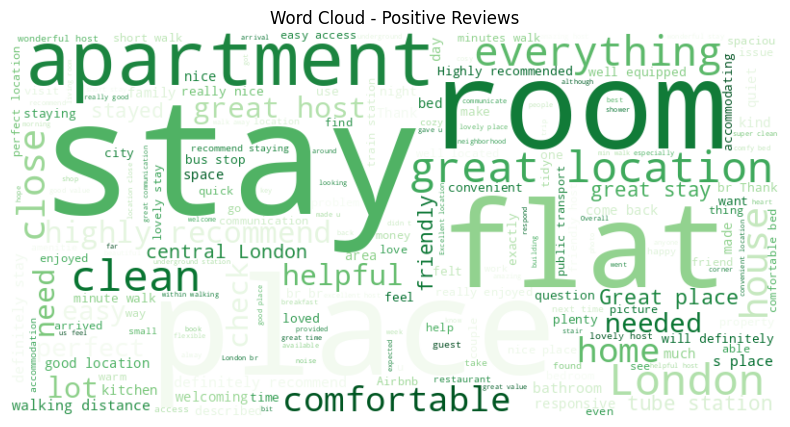

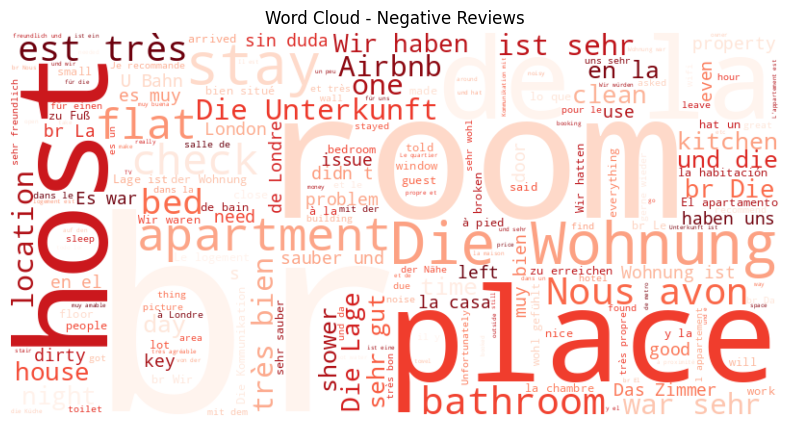

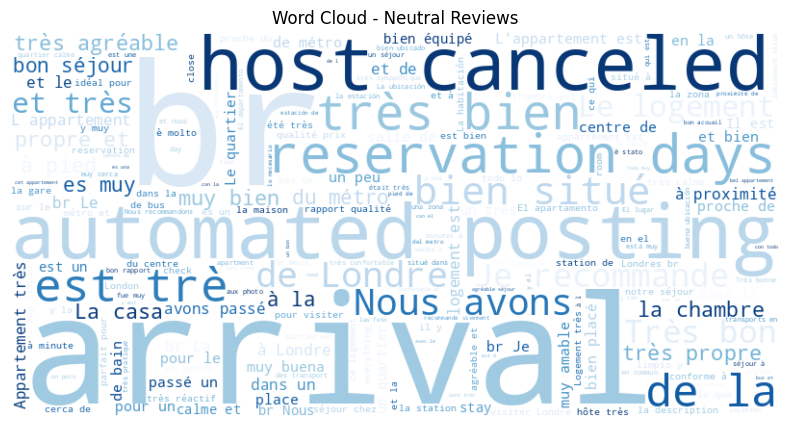

In [24]:
from wordcloud import WordCloud

# WORDCLOUD
# Generate word clouds for positive and negative reviews
positive_reviews = ' '.join(reviews[reviews['sentiment_vader'] == 'positive']['comments'])
negative_reviews = ' '.join(reviews[reviews['sentiment_vader'] == 'negative']['comments'])
neutral_reviews = ' '.join(reviews[reviews['sentiment_vader'] == 'neutral']['comments'])

# Word cloud for positive reviews
plt.figure(figsize=(10, 5))
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_reviews)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Reviews')
plt.show()

# Word cloud for negative reviews
plt.figure(figsize=(10, 5))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_reviews)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Reviews')
plt.show()

# Word cloud for neutral reviews
plt.figure(figsize=(10, 5))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(neutral_reviews)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Neutral Reviews')
plt.show()

<Figure size 800x600 with 0 Axes>

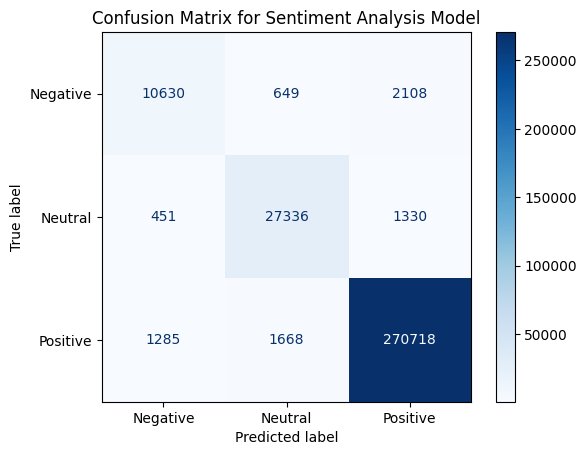

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot the confusion matrix for the classifier
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(classifier, X_test_tfidf, y_test, cmap='Blues', display_labels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix for Sentiment Analysis Model')
plt.show()

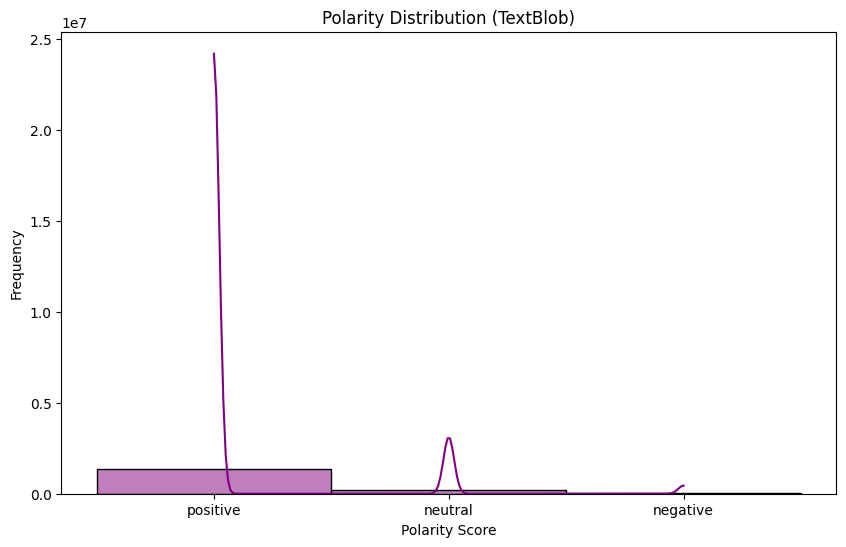

In [25]:
# Calculate TextBlob polarity scores for each review
# reviews['polarity'] = reviews['comments'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot the polarity distribution
plt.figure(figsize=(10, 6))
sns.histplot(reviews['sentiment_textblob'], bins=30, kde=True, color='purple')
plt.title('Polarity Distribution (TextBlob)')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

#Coorelation analysis

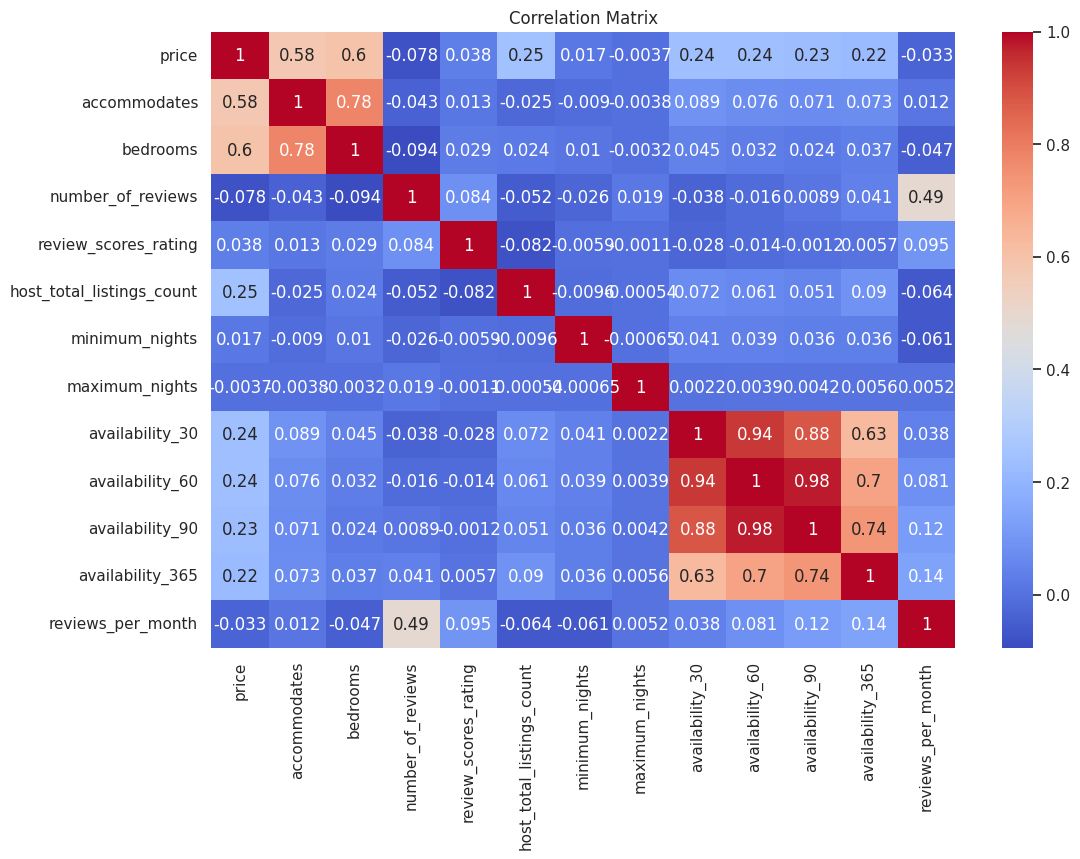

In [ ]:
# Correlation matrix
plt.figure(figsize=(12, 8))
listings_for_correlation = listings[['price', 'accommodates', 'bedrooms', 'number_of_reviews', 'review_scores_rating',
                                     'host_total_listings_count', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60',
                                     'availability_90', 'availability_365', 'reviews_per_month']]
sns.heatmap(listings_for_correlation.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#Preditive modeling

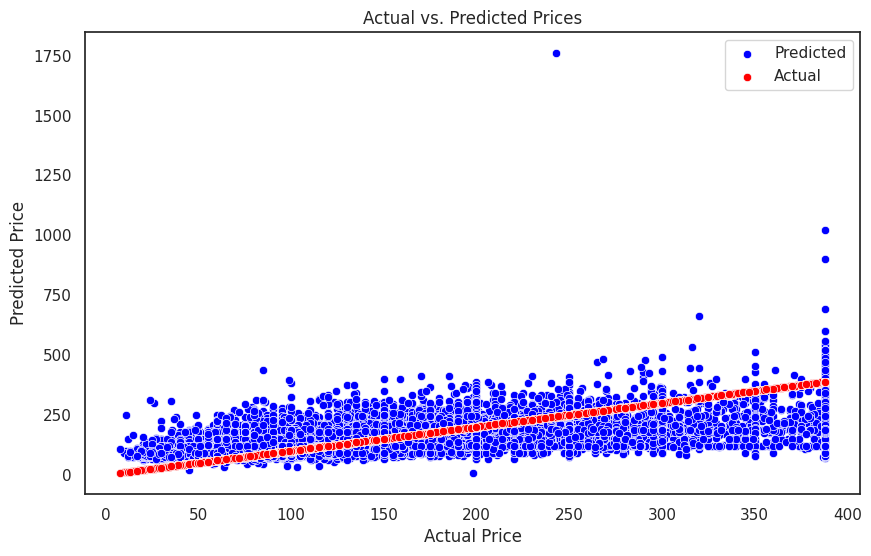

In [ ]:
# Select features (X) and target variable (y)
X = listings[['accommodates', 'bedrooms', 'bathrooms', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
y = listings['price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Create a scatter plot with different colors for actual and predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Predicted')
sns.scatterplot(x=y_test, y=y_test, color='red', label='Actual')  # Plot actual values against themselves

plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 6632.231187015174
R-squared: 0.3899743155400398


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define target and features
y = listings['price']
X = listings[['neighbourhood', 'room_type', 'bedrooms', 'bathrooms', 'accommodates', 'number_of_reviews', 'minimum_nights', 'reviews_per_month']]

In [ ]:
# Define categorical and numerical features
categorical_features = ['neighbourhood', 'room_type']
numerical_features = ['bedrooms', 'bathrooms', 'accommodates', 'number_of_reviews', 'minimum_nights', 'reviews_per_month']

# Create preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Initialize models
models = {
    "Linear Regression": Pipeline([('preprocessor', preprocessor),
                                   ('regressor', LinearRegression())]),
    "Ridge Regression": Pipeline([('preprocessor', preprocessor),
                                  ('regressor', Ridge())]),
    "Lasso Regression": Pipeline([('preprocessor', preprocessor),
                                  ('regressor', Lasso())]),
    "Decision Tree": Pipeline([('preprocessor', preprocessor),
                               ('regressor', DecisionTreeRegressor(random_state=42))]),
    "Random Forest": Pipeline([('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor(random_state=42))]),
    "XGBoost": Pipeline([('preprocessor', preprocessor),
                         ('regressor', XGBRegressor(random_state=42))]),
    "Support Vector Regressor": Pipeline([('preprocessor', preprocessor),
                                          ('regressor', SVR())]),
    "K-Nearest Neighbors": Pipeline([('preprocessor', preprocessor),
                                     ('regressor', KNeighborsRegressor())])
}

# Train each model and store predictions and metrics
model_results = {}
for model_name, model_pipeline in models.items():
    # Train the model
    model_pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model_pipeline.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    model_results[model_name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

# Display each model's metrics
for model_name, metrics in model_results.items():
    print(f"{model_name} Results:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
    print("\n")

Linear Regression Results:
  MAE: 55.9656
  MSE: 6111.4732
  RMSE: 78.1759
  R2: 0.4379


Ridge Regression Results:
  MAE: 55.9173
  MSE: 6102.1960
  RMSE: 78.1166
  R2: 0.4387


Lasso Regression Results:
  MAE: 56.7090
  MSE: 6261.0002
  RMSE: 79.1265
  R2: 0.4241


Decision Tree Results:
  MAE: 55.5887
  MSE: 6299.2887
  RMSE: 79.3681
  R2: 0.4206


Random Forest Results:
  MAE: 54.0438
  MSE: 5807.1806
  RMSE: 76.2049
  R2: 0.4659


XGBoost Results:
  MAE: 52.4637
  MSE: 5386.8536
  RMSE: 73.3952
  R2: 0.5045


Support Vector Regressor Results:
  MAE: 52.2483
  MSE: 6146.6684
  RMSE: 78.4007
  R2: 0.4346


K-Nearest Neighbors Results:
  MAE: 56.9448
  MSE: 6457.7299
  RMSE: 80.3600
  R2: 0.4060




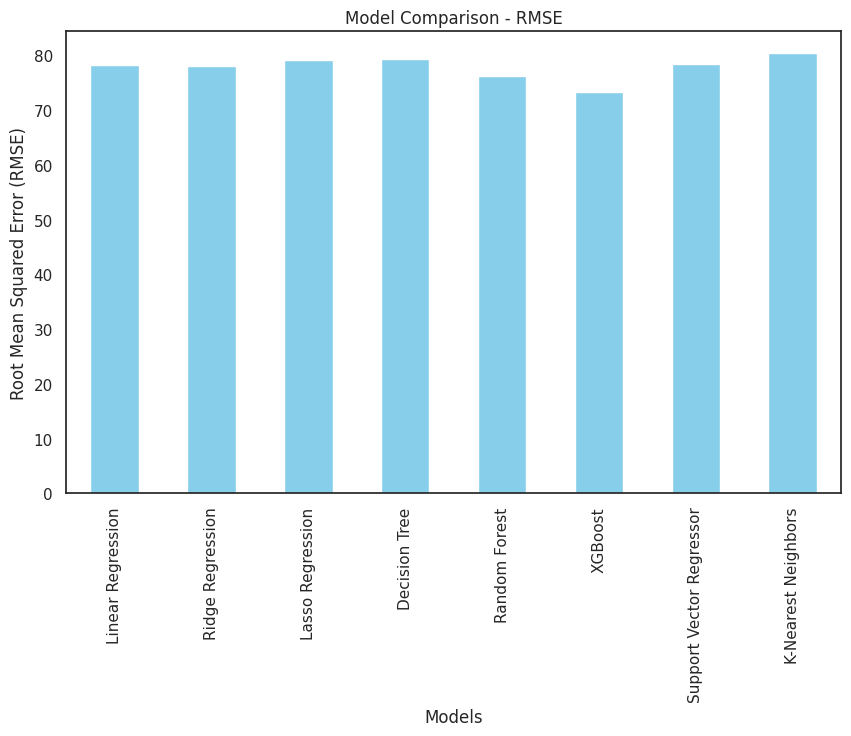

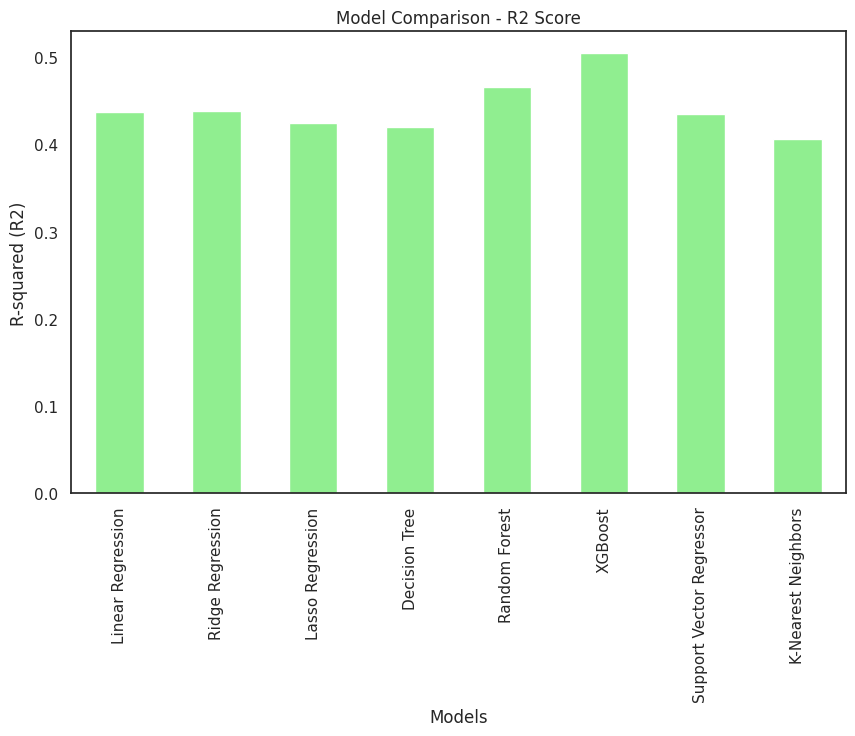

In [ ]:
# Convert model results to DataFrame for visualization
results_df = pd.DataFrame(model_results).T

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
results_df['RMSE'].plot(kind='bar', color='skyblue')
plt.title('Model Comparison - RMSE')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xlabel('Models')
plt.show()

# Plot R2 score comparison
plt.figure(figsize=(10, 6))
results_df['R2'].plot(kind='bar', color='lightgreen')
plt.title('Model Comparison - R2 Score')
plt.ylabel('R-squared (R2)')
plt.xlabel('Models')
plt.show()


The results are displayed in bar plots to visually compare each model's RMSE and R2 scores. Generally, a lower RMSE and a higher R2 score indicate better model performance. Thus, XGBoost model performs the best.

#Clustering

In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# Select features for clustering (customize based on available columns)
features = ['price', 'number_of_reviews', 'neighbourhood', 'room_type', 'accommodates', 'bedrooms', 'minimum_nights', 'reviews_per_month']

# Extract selected features
X = listings[features]

# Define categorical and numerical features
categorical_features = ['neighbourhood', 'room_type']
numerical_features = ['price', 'number_of_reviews', 'accommodates', 'bedrooms', 'minimum_nights', 'reviews_per_month']

# Preprocess using StandardScaler for numeric data and OneHotEncoder for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Apply the transformation
X_transformed = preprocessor.fit_transform(X)

###k means clustering

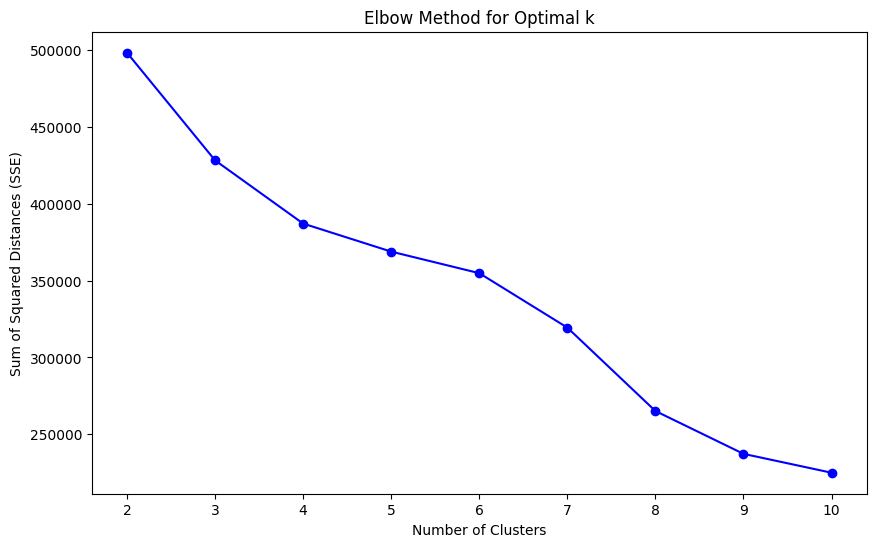

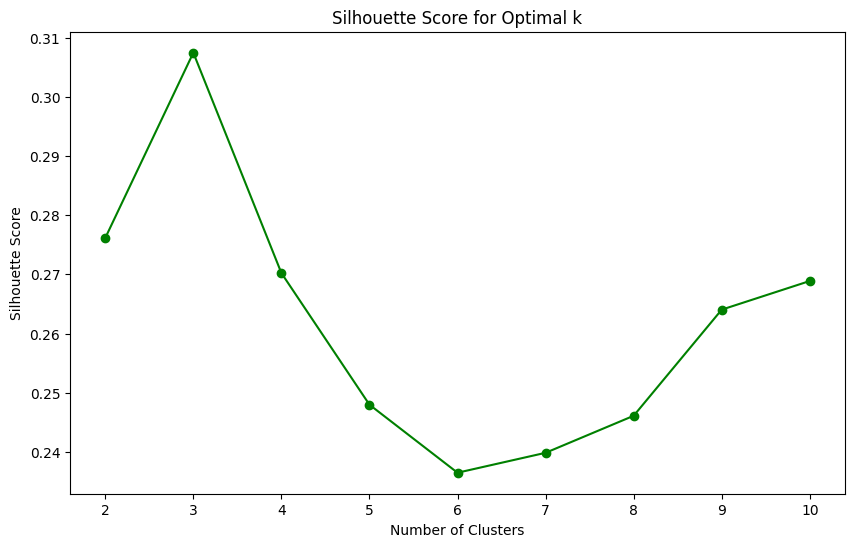

In [24]:
from sklearn.metrics import silhouette_score

# Elbow Method to determine optimal number of clusters
sse = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_transformed)
    sse.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center
    silhouette_scores.append(silhouette_score(X_transformed, kmeans.labels_))

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sse, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.show()

# Plot the silhouette score curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [30]:
# Fit K-means with the optimal number of clusters (choose based on elbow method)
optimal_k = 3  # Replace with the chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_transformed)

# Add the cluster labels to the original data
listings['cluster_kmeans'] = clusters

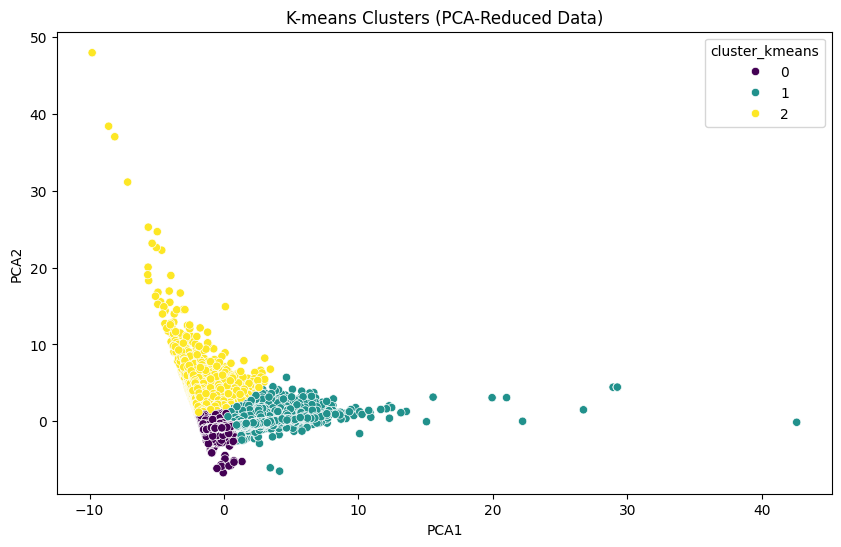

In [31]:
from sklearn.decomposition import PCA

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

# Add PCA results to the DataFrame for visualization
listings['PCA1'] = X_pca[:, 0]
listings['PCA2'] = X_pca[:, 1]

# Plot K-means clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_kmeans', data=listings, palette='viridis')
plt.title('K-means Clusters (PCA-Reduced Data)')
plt.show()